In [0]:
from google.colab import files
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv1d, Conv2d, Linear
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.special import expit
from tqdm import tqdm
import io
import re
from google.colab import files
import math
import random
import gc
import zipfile

In [0]:
import nltk
import spacy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from nltk import agreement
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from scipy.stats import spearmanr
from torch.nn import CosineSimilarity
from torch.nn import functional
from collections import Counter
from sklearn.metrics import matthews_corrcoef
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [0]:
%%shell
pip install allennlp;

In [0]:
from typing import Iterator, List, Dict, Optional
from allennlp.data import Instance
from allennlp.data.fields import TextField, SequenceLabelField, LabelField, ArrayField
from allennlp.data.dataset_readers import DatasetReader
from allennlp.common.file_utils import cached_path
from allennlp.common.util import START_SYMBOL, END_SYMBOL
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer, PretrainedBertIndexer
from allennlp.data.token_indexers.elmo_indexer import ELMoTokenCharactersIndexer
from allennlp.data.tokenizers import Token
from allennlp.data.vocabulary import Vocabulary
from allennlp.nn.activations import Activation
from allennlp.models import Model, BiattentiveClassificationNetwork
from allennlp.modules.attention import LinearAttention, BilinearAttention, DotProductAttention
from allennlp.modules.feedforward import FeedForward
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders.bert_token_embedder import PretrainedBertEmbedder
from allennlp.models.encoder_decoders.simple_seq2seq import SimpleSeq2Seq
from allennlp.modules.token_embedders import Embedding, ElmoTokenEmbedder
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder, PytorchSeq2SeqWrapper, StackedSelfAttentionEncoder
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, PytorchSeq2VecWrapper, CnnEncoder
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.nn.activations import Activation
from allennlp.data.iterators import BucketIterator, BasicIterator, DataIterator
from allennlp.training.trainer import Trainer
from allennlp.predictors import SimpleSeq2SeqPredictor
from allennlp.predictors.seq2seq import Seq2SeqPredictor
from allennlp.nn import util as nn_util
from allennlp.predictors import SentenceTaggerPredictor

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1);

CUDA_DEVICE = 0

# Data Loading and Preparation

In [0]:
bio_path = "/content/BIO---Protein-Classification/"

In [7]:
!git clone https://github.com/catalinAioanei/BIO---Protein-Classification

Cloning into 'BIO---Protein-Classification'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


#### Preparing the annotated proteins files

In [0]:
nucleus_proteins = open(bio_path + "nucleus.fasta.txt", 'r')
nucleus_proteins = nucleus_proteins.read()
nucleus_proteins = nucleus_proteins.split(">sp")[1:]
nucleus_proteins = {"Header":[protein.split("\n", 1)[0] for protein in nucleus_proteins], 
                "Sequence": [protein.split("\n",1)[1].replace("\n", "") for protein in nucleus_proteins], 
                "Label": "nucleus"}
nucleus_proteins = pd.DataFrame(nucleus_proteins)


cito_proteins = open(bio_path + "cito.fasta.txt", 'r')
cito_proteins = cito_proteins.read()
cito_proteins = cito_proteins.split(">sp")[1:]
cito_proteins = {"Header":[protein.split("\n", 1)[0] for protein in cito_proteins], 
                "Sequence": [protein.split("\n",1)[1].replace("\n", "") for protein in cito_proteins], 
                "Label": "cito"}
cito_proteins = pd.DataFrame(cito_proteins)


mito_proteins = open(bio_path + "mito.fasta.txt", 'r')
mito_proteins = mito_proteins.read()
mito_proteins = mito_proteins.split(">sp")[1:]
mito_proteins = {"Header":[protein.split("\n", 1)[0] for protein in mito_proteins], 
                "Sequence": [protein.split("\n",1)[1].replace("\n", "") for protein in mito_proteins], 
                "Label": "mito"}
mito_proteins = pd.DataFrame(mito_proteins)


secreted_proteins = open(bio_path + "secreted.fasta.txt", 'r')
secreted_proteins = secreted_proteins.read()
secreted_proteins = secreted_proteins.split(">sp")[1:]
secreted_proteins = {"Header":[protein.split("\n", 1)[0] for protein in secreted_proteins], 
                "Sequence": [protein.split("\n",1)[1].replace("\n", "") for protein in secreted_proteins], 
                "Label": "secreted"}
secreted_proteins = pd.DataFrame(secreted_proteins)
                

##### Preparing the blind test proteins file

In [0]:
blind_test = open(bio_path + "blind_test.fasta.txt", 'r')
blind_test = blind_test.read()
blind_test = blind_test.split(">")[1:]

blind_test = {"Header":[protein.split("\n", 1)[0] for protein in blind_test], 
              "Sequence": [protein.split("\n",1)[1].replace("\n", "") for protein in blind_test],
              "Label": "mito"} 
# we put mito label just as a hack, so that the predictor will stop complayining
# ignore the label field for the blind_test dataframe and just focus on the prediction column
blind_test = pd.DataFrame(blind_test)

#### Checking our available data

In [10]:
print("For this experiment, we have available:\n")
print(str(len(cito_proteins))     + " Cytosolic proteins;")
print(str(len(secreted_proteins)) + " Secreted proteins;")
print(str(len(nucleus_proteins))  + " Nuclear proteins;" )
print(str(len(mito_proteins))     + " Mitochondrial proteins;")
print(str(len(blind_test))        + " Blind test proteins;")

For this experiment, we have available:

3314 Cytosolic proteins;
1605 Secreted proteins;
3314 Nuclear proteins;
1299 Mitochondrial proteins;
20 Blind test proteins;


## Preparing different train/dev/test splits for cross-validation

Here, we take all  available labeled proteins and split them in equal-sized chunks, where the distribution of the type of proteins is the same across each chunk. The chunk size wil differ for each ratio of splits we inted to use

In [0]:
available_data = pd.concat([cito_proteins, secreted_proteins, nucleus_proteins, mito_proteins])
available_data = available_data.sample(frac=1).reset_index(drop=True)

#### 60% train, 20% validation, 20% test 
(k-fold cross-validation with k = 5)

In [0]:
data_splits = []

for i in range(5):
  train, dev, test = np.split(available_data.sample(frac=1), [int(.6*len(available_data)), int(.8*len(available_data))])
  train = train.reset_index(drop=True)
  dev   = dev.reset_index(drop=True)
  test  = test.reset_index(drop=True)

  data_splits.append({"df":(train, dev, test)})


# Reading and preparing the Dataset 

In [0]:
class ProteinReader(DatasetReader):
  def __init__(self, lazy=False, vocab: Vocabulary=None, token_indexers = None) -> None:
    super().__init__(lazy=lazy)
    self.reject_probs = None
    self._token_indexers = token_indexers or {"tokens": SingleIdTokenIndexer(lowercase_tokens=False)}
  
  def _read(self, data:pd.DataFrame)->Iterator[Instance]:

    for index, row in data.iterrows():
      header = row["Header"]
      sequence = row["Sequence"]
      label = row["Label"]
  
      yield self.text_to_instance(header, sequence, label)
  
  def text_to_instance(self, header: str, sequence: str, label)->Instance:
    sequence_field = TextField([Token(w) for w in sequence], token_indexers = self._token_indexers)
    label_field = LabelField(label)
    
    
    return Instance({"tokens": sequence_field, "label": label_field})

In [14]:
reader = ProteinReader()

for data_split in data_splits:
  train_data = reader.read(data_split["df"][0])
  dev_data   = reader.read(data_split["df"][1])
  test_data  = reader.read(data_split["df"][2])

  data_split["inst"] = (train_data, dev_data, test_data)

vocab = Vocabulary.from_instances(train_data + dev_data + test_data)
iterator = BucketIterator(batch_size=64, biggest_batch_first=True, sorting_keys=[("tokens", "num_tokens")])
iterator.index_with(vocab)

5719it [00:06, 862.04it/s] 
1906it [00:02, 679.58it/s] 
1907it [00:02, 825.43it/s] 
5719it [00:06, 853.60it/s] 
1906it [00:01, 1501.74it/s]
1907it [00:03, 563.68it/s]
5719it [00:06, 904.39it/s]
1906it [00:01, 1497.96it/s]
1907it [00:01, 1469.21it/s]
5719it [00:06, 818.00it/s] 
1906it [00:01, 1491.17it/s]
1907it [00:05, 369.83it/s]
5719it [00:03, 1453.99it/s]
1906it [00:01, 1534.92it/s]
1907it [00:06, 312.27it/s]
100%|██████████| 9532/9532 [00:02<00:00, 3807.05it/s]


# Preparing the Predictor class

This is the class that will help us get our predictions and metrics, from our trained models

In [0]:
def tonp(tsr): return tsr.detach().cpu().numpy()

def get_label(prediction):
  return np.argmax(prediction)

class Predictor:
    def __init__(self, model: Model, iterator,
                 cuda_device: int=CUDA_DEVICE) -> None:
        self.model = model
        self.iterator = iterator
        self.cuda_device = cuda_device
         
    def _extract_data(self, batch) -> np.ndarray:
        out_dict = self.model(**batch)
        return expit(tonp(out_dict["class_logits"]))
     
    def predict(self, ds) -> np.ndarray:
        pred_generator = self.iterator(ds, num_epochs=1, shuffle=False)
        self.model.eval()
        pred_generator_tqdm = tqdm(pred_generator,
                                   total=self.iterator.get_num_batches(ds))
        preds = []
        with torch.no_grad():
            for batch in pred_generator_tqdm:
                batch = nn_util.move_to_device(batch, self.cuda_device)
                preds.append(self._extract_data(batch))

        return np.concatenate(preds, axis=0)

    def update_dataset_with_predictions(self, predictions, data):
      predictions = F.softmax(torch.Tensor(predictions), dim = 1).numpy()
      labels = np.apply_along_axis(get_label, axis=1, arr=predictions)
      confidence = np.apply_along_axis(max, axis = 1, arr = predictions)

      res = pd.DataFrame({"PredictionIndex": labels, "Confidence":confidence})
      res["Prediction"] = res["PredictionIndex"].apply(lambda x: vocab.get_token_from_index(x, namespace = 'labels'))
      
      # data = pd.read_csv(path)
      if data.shape[0] == res.shape[0]:
        data['Prediction'] = res['Prediction']
        data['Confidence'] = res['Confidence']
        return data
      else:
        print("\nShape of predictions and shape of passed dataframe are incompatible")
      return None
    
    def getConfusionMatrix(self, data):
      return pd.crosstab(data['Label'], data['Prediction'])

    def getAccuracy(self, data):
      return sum((data['Label'] == data["Prediction"]).tolist()) / data.shape[0]

    def getMetricsReport(self, data):
      return metrics.classification_report(data['Label'], data['Prediction'], digits=3)

    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """ 
        import itertools
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


        plt.figure(figsize=(6,6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

# Models

During development we ran each of the models bellow on all of the data splits. However, for the sake of brevity, here we train just the first model on all 5 splits and give summarised results, while the rest of the models are trained on just one split (otherwise you are looking at spending a lot of time in this notebook). Simply modify each model's training loop and make it similar to the first one's to train them on all splits as well.

### LSTM Encoder Model

In [0]:
class LSTMModel(Model):
  def __init__(self, protein_embeddings: TextFieldEmbedder, protein_seq_encoder: Seq2VecEncoder,
               out_sz :int=4, vocab: Vocabulary=None):
    super().__init__(vocab)
    self.protein_embeddings = protein_embeddings
    self.protein_seq_encoder = protein_seq_encoder
    self.out_sz = out_sz

    self.first_projection = nn.Linear(self.protein_seq_encoder.get_output_dim(), int(self.protein_seq_encoder.get_output_dim() /2 ))
    self.last_projection = nn.Linear(int(self.protein_seq_encoder.get_output_dim() /2 ), out_sz)

    self.loss = nn.BCEWithLogitsLoss()
  
  # tokens: Dict[str, torch.Tensor], id, label: torch.Tensor
  def forward(self, tokens, label) -> torch.Tensor:

    mask = get_text_field_mask(tokens)
    embeddings = self.protein_embeddings(tokens)

    state = self.protein_seq_encoder(embeddings, mask)

    state = F.relu(self.first_projection(state))
    class_logits = self.last_projection(state)

    one_hot_label = F.one_hot(label.long(), self.out_sz).float()

    output = {"class_logits": class_logits}
    output["loss"] = self.loss(class_logits, one_hot_label)

    return output

Training loop for each of the split (again, only this model will be trained all splits, while the rest will be trained on just one split)

In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 300
NUM_EPOCHS    = 20

models_per_split = []
for data_split in data_splits:
  train_data = data_split["inst"][0]
  dev_data   = data_split["inst"][1]
  test_data  = data_split["inst"][2]

  token_embedding = Embedding(num_embeddings=vocab.get_vocab_size(), embedding_dim=EMBEDDING_DIM, padding_index=0)
  protein_embeddings: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": token_embedding})

  protein_seq_encoder: Seq2VecEncoder = PytorchSeq2VecWrapper(nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, bidirectional=True, num_layers = 1, batch_first=True))

  model = LSTMModel(protein_embeddings, protein_seq_encoder).to(device)
  CUDA_DEVICE = 0

  trainer = Trainer(
      model=model,
      optimizer=optim.Adam(model.parameters(), lr=0.005),
      iterator=iterator,
      train_dataset=train_data,
      validation_dataset=dev_data,
      patience=3,
      cuda_device=CUDA_DEVICE,
      num_epochs=NUM_EPOCHS,
  )

  trainer.train()
  print("\n\nModel Trained\n")
  models_per_split.append(model)

  


#### Evaluating Results

In [0]:
# Again, for the sake of brevity, we display the results of the model trained on just the first split
# The results for the entire architecture, are the average of the results of the models in the list models_per_split

index = 0
model = models_per_split[index]
train_data = data_splits[index]["inst"][0]
dev_data   = data_splits[index]["inst"][1]
test_data  = data_splits[index]["inst"][2]

seq_iterator = BasicIterator(batch_size=64)
seq_iterator.index_with(vocab)
predictor = Predictor(model, seq_iterator, cuda_device=CUDA_DEVICE)

train_predictions = predictor.predict(train_data)
dev_predictions   = predictor.predict(dev_data)
test_predictions  = predictor.predict(test_data)

updated_train_data = predictor.update_dataset_with_predictions(train_predictions, df_train_data)
updated_dev_data   = predictor.update_dataset_with_predictions(dev_predictions, df_dev_data)
updated_test_data  = predictor.update_dataset_with_predictions(test_predictions, df_test_data)

print("\n\nTrain Accuracy: " + str(predictor.getAccuracy(updated_train_data)))
print("Dev Accuracy: "     + str(predictor.getAccuracy(updated_dev_data)))
print("Test Accuracy: "    + str(predictor.getAccuracy(updated_test_data)))

print("\nGorodkin Coeff. - Train: " + str(matthews_corrcoef(updated_train_data['Label'], updated_train_data['Prediction'])))
print("Gorodkin Coeff. - Dev: "   + str(matthews_corrcoef(updated_dev_data['Label'], updated_dev_data['Prediction'])))
print("Gorodkin Coeff. - Test: "  + str(matthews_corrcoef(updated_test_data['Label'], updated_test_data['Prediction'])))

In [0]:
print("Metrics Report:\n")
print(predictor.getMetricsReport(updated_test_data))

### CNN Encoder Model

In [0]:
class CNNModel(Model):
  def __init__(self, protein_embeddings: TextFieldEmbedder, protein_seq_encoder: Seq2VecEncoder,
               out_sz :int=4, vocab: Vocabulary=None):
    super().__init__(vocab)
    self.protein_embeddings = protein_embeddings
    self.protein_seq_encoder = protein_seq_encoder
    self.out_sz = out_sz
    self.projection = nn.Linear(self.protein_seq_encoder.get_output_dim(), out_sz)
    self.loss = nn.BCEWithLogitsLoss()
  
  # tokens: Dict[str, torch.Tensor], id, label: torch.Tensor
  def forward(self, tokens, label) -> torch.Tensor:

    mask = get_text_field_mask(tokens)
    embeddings = self.protein_embeddings(tokens)
    state = self.protein_seq_encoder(embeddings, mask)

    class_logits = self.projection(state)
    one_hot_label = F.one_hot(label.long(), self.out_sz).float()

    output = {"class_logits": class_logits}
    output["loss"] = self.loss(class_logits, one_hot_label)

    return output

In [0]:
train_data = data_splits[0]["inst"][0]
dev_data   = data_splits[0]["inst"][1]
test_data  = data_splits[0]["inst"][2]

df_train_data = data_splits[0]["df"][0]
df_dev_data   = data_splits[0]["df"][1]
df_test_data  = data_splits[0]["df"][2]

EMBEDDING_DIM = 300
HIDDEN_DIM    = 300
NUM_EPOCHS    = 30

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size(), embedding_dim=EMBEDDING_DIM, padding_index=0)
protein_embeddings: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": token_embedding})

protein_seq_encoder = CnnEncoder(embedding_dim=EMBEDDING_DIM, num_filters=300, ngram_filter_sizes = (2, 3, 4, 5)) 

model = CNNModel(protein_embeddings, protein_seq_encoder).to(device)
CUDA_DEVICE = 0

trainer = Trainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.001),
    iterator=iterator,
    train_dataset=train_data,
    validation_dataset=dev_data,
    patience=2,
    cuda_device=CUDA_DEVICE,
    num_epochs=NUM_EPOCHS,
)

trainer.train()
gc.collect()

In [0]:
seq_iterator = BasicIterator(batch_size=64)
seq_iterator.index_with(vocab)
predictor = Predictor(model, seq_iterator, cuda_device=CUDA_DEVICE)

train_predictions = predictor.predict(train_data)
dev_predictions   = predictor.predict(dev_data)
test_predictions  = predictor.predict(test_data)

updated_train_data = predictor.update_dataset_with_predictions(train_predictions, df_train_data)
updated_dev_data   = predictor.update_dataset_with_predictions(dev_predictions, df_dev_data)
updated_test_data  = predictor.update_dataset_with_predictions(test_predictions, df_test_data)

print("\n\nTrain Accuracy: " + str(predictor.getAccuracy(updated_train_data)))
print("Dev Accuracy: "     + str(predictor.getAccuracy(updated_dev_data)))
print("Test Accuracy: "    + str(predictor.getAccuracy(updated_test_data)))

print("\nGorodkin Coeff. - Train: " + str(matthews_corrcoef(updated_train_data['Label'], updated_train_data['Prediction'])))
print("Gorodkin Coeff. - Dev: "   + str(matthews_corrcoef(updated_dev_data['Label'], updated_dev_data['Prediction'])))
print("Gorodkin Coeff. - Test: "  + str(matthews_corrcoef(updated_test_data['Label'], updated_test_data['Prediction'])))

In [0]:
print("Metrics Report:\n")
print(predictor.getMetricsReport(updated_test_data))

### CNN - LSTM Hybrid 1

In [0]:
class LSTM_CNN_Model(Model):
  def __init__(self, protein_embeddings: TextFieldEmbedder, protein_LSTM_encoder: Seq2SeqEncoder, 
               protein_CNN_encoder: Seq2VecEncoder, out_sz :int=4, vocab: Vocabulary=None):
    super().__init__(vocab)
    self.protein_embeddings = protein_embeddings
    self.protein_LSTM_encoder = protein_LSTM_encoder
    self.protein_CNN_encoder = protein_CNN_encoder
    self.out_sz = out_sz

    self.first_projection = nn.Linear(self.protein_CNN_encoder.get_output_dim(), int(self.protein_CNN_encoder.get_output_dim() /2 ))
    self.last_projection = nn.Linear(int(self.protein_CNN_encoder.get_output_dim() /2 ), out_sz)

    self.loss = nn.BCEWithLogitsLoss()
  
  # tokens: Dict[str, torch.Tensor], id, label: torch.Tensor
  def forward(self, tokens, label) -> torch.Tensor:

    mask = get_text_field_mask(tokens)
    embeddings = self.protein_embeddings(tokens)
    
    lstm_encodings = self.protein_LSTM_encoder(embeddings, mask)
    lstm_mask = get_text_field_mask({"tokens":lstm_encodings})
    
    state = self.protein_CNN_encoder(lstm_encodings, lstm_mask)

    state = F.relu(self.first_projection(state))
    class_logits = self.last_projection(state)
    
    one_hot_label = F.one_hot(label.long(), self.out_sz).float()

    output = {"class_logits": class_logits}
    output["loss"] = self.loss(class_logits, one_hot_label)

    return output

In [17]:
train_data = data_splits[0]["inst"][0]
dev_data   = data_splits[0]["inst"][1]
test_data  = data_splits[0]["inst"][2]

df_train_data = data_splits[0]["df"][0]
df_dev_data   = data_splits[0]["df"][1]
df_test_data  = data_splits[0]["df"][2]

EMBEDDING_DIM = 256
HIDDEN_DIM    = 256
NUM_EPOCHS    = 30

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size(), embedding_dim=EMBEDDING_DIM, padding_index=0)
protein_embeddings: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": token_embedding})

protein_LSTM_encoder = PytorchSeq2SeqWrapper(nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, bidirectional=True, batch_first=True))
protein_CNN_encoder = CnnEncoder(embedding_dim=protein_LSTM_encoder.get_output_dim(), num_filters=300, ngram_filter_sizes = (2, 3, 4, 5))


model = LSTM_CNN_Model(protein_embeddings, protein_LSTM_encoder, protein_CNN_encoder).to(device)
CUDA_DEVICE = 0

trainer = Trainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.002),
    iterator=iterator,
    train_dataset=train_data,
    validation_dataset=dev_data,
    patience=3,
    cuda_device=CUDA_DEVICE,
    num_epochs=NUM_EPOCHS,
)

trainer.train()
gc.collect()

loss: 0.5306 ||: 100%|██████████| 90/90 [00:26<00:00,  3.35it/s]
loss: 0.5036 ||: 100%|██████████| 30/30 [00:03<00:00,  7.53it/s]
loss: 0.5163 ||: 100%|██████████| 90/90 [00:24<00:00,  3.73it/s]
loss: 0.4756 ||: 100%|██████████| 30/30 [00:03<00:00,  9.77it/s]
loss: 0.4744 ||: 100%|██████████| 90/90 [00:24<00:00,  3.73it/s]
loss: 0.4385 ||: 100%|██████████| 30/30 [00:03<00:00,  9.50it/s]
loss: 0.4046 ||: 100%|██████████| 90/90 [00:24<00:00,  3.72it/s]
loss: 0.3878 ||: 100%|██████████| 30/30 [00:03<00:00,  9.62it/s]
loss: 0.3521 ||: 100%|██████████| 90/90 [00:24<00:00,  3.73it/s]
loss: 0.3744 ||: 100%|██████████| 30/30 [00:03<00:00,  9.55it/s]
loss: 0.3302 ||: 100%|██████████| 90/90 [00:24<00:00,  3.72it/s]
loss: 0.3575 ||: 100%|██████████| 30/30 [00:03<00:00,  9.48it/s]
loss: 0.3219 ||: 100%|██████████| 90/90 [00:24<00:00,  3.72it/s]
loss: 0.3352 ||: 100%|██████████| 30/30 [00:03<00:00,  9.72it/s]
loss: 0.3113 ||: 100%|██████████| 90/90 [00:24<00:00,  3.71it/s]
loss: 0.3441 ||: 100%|███

KeyboardInterrupt: ignored

In [0]:
seq_iterator = BasicIterator(batch_size=64)
seq_iterator.index_with(vocab)
predictor = Predictor(model, seq_iterator, cuda_device=CUDA_DEVICE)

train_predictions = predictor.predict(train_data)
dev_predictions   = predictor.predict(dev_data)
test_predictions  = predictor.predict(test_data)

updated_train_data = predictor.update_dataset_with_predictions(train_predictions, df_train_data)
updated_dev_data   = predictor.update_dataset_with_predictions(dev_predictions, df_dev_data)
updated_test_data  = predictor.update_dataset_with_predictions(test_predictions, df_test_data)

print("\n\nTrain Accuracy: " + str(predictor.getAccuracy(updated_train_data)))
print("Dev Accuracy: "     + str(predictor.getAccuracy(updated_dev_data)))
print("Test Accuracy: "    + str(predictor.getAccuracy(updated_test_data)))

print("\nGorodkin Coeff. - Train: " + str(matthews_corrcoef(updated_train_data['Label'], updated_train_data['Prediction'])))
print("Gorodkin Coeff. - Dev: "   + str(matthews_corrcoef(updated_dev_data['Label'], updated_dev_data['Prediction'])))
print("Gorodkin Coeff. - Test: "  + str(matthews_corrcoef(updated_test_data['Label'], updated_test_data['Prediction'])))

100%|██████████| 30/30 [00:08<00:00,  3.65it/s]



Train Accuracy: 0.642594859241126
Dev Accuracy: 0.602308499475341
Test Accuracy: 0.5920293654955427

Gorodkin Coeff. - Train: 0.6150793531578164
Gorodkin Coeff. - Dev: 0.5434327005649392
Gorodkin Coeff. - Test: 0.5409657716823505


In [0]:
print("Metrics Report:\n")
print(predictor.getMetricsReport(updated_test_data))

Metrics Report:

              precision    recall  f1-score   support

        cito      0.475     0.952     0.634       681
        mito      0.860     0.717     0.782       240
     nucleus      0.243     0.013     0.025       671
    secreted      0.954     0.930     0.942       315

    accuracy                          0.588      1907
   macro avg      0.633     0.653     0.596      1907
weighted avg      0.521     0.588     0.489      1907



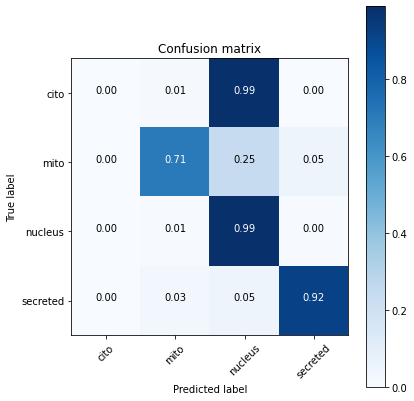

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(updated_test_data['Label'], updated_test_data['Prediction'], labels =  ['cito', 'mito', 'nucleus', 'secreted'] )
predictor.plot_confusion_matrix(cm, ['cito', 'mito', 'nucleus', 'secreted'], 
                                normalize=True, title = 'Confusion matrix')

### CNN - LSTM Hybrid 2

In [0]:
class CNN_LSTM_Model(Model):
  def __init__(self, protein_embeddings: TextFieldEmbedder, cnn_encoder: nn.Conv2d, protein_LSTM_encoder: Seq2VecEncoder, 
               out_sz :int=4, vocab: Vocabulary=None):
    super().__init__(vocab)
    self.protein_embeddings = protein_embeddings
    self.cnn_encoder = cnn_encoder

    self.protein_LSTM_encoder = protein_LSTM_encoder
    self.out_sz = out_sz

    self.first_projection = nn.Linear(self.protein_LSTM_encoder.get_output_dim(), int(self.protein_LSTM_encoder.get_output_dim() /2 ))
    self.last_projection = nn.Linear(int(self.protein_LSTM_encoder.get_output_dim() /2 ), out_sz)

    self.loss = nn.BCEWithLogitsLoss()

  def get_mask_from_batch(self, x):
    ret = ()
    for instance in x:
      instance = instance.clone().detach().cpu().numpy()
      ret = ret + (self.get_mask(instance),)
  
    return torch.stack(ret)

  def get_mask(self, instance):
    mask = np.logical_not((instance[1:] == instance[:-1]).all(axis = 1))
    mask = torch.Tensor(mask)

    if mask[-1] and not sum(instance[-1] == instance[-2]):
      mask = torch.cat((mask.int(), torch.tensor([1], dtype = torch.int32))).long()
    else:
      mask = torch.cat((mask.int(), torch.tensor([0], dtype = torch.int32))).long()
    return mask
  
  # tokens: Dict[str, torch.Tensor], id, label: torch.Tensor
  def forward(self, tokens, label) -> torch.Tensor:

    mask = get_text_field_mask(tokens)
    embeddings = self.protein_embeddings(tokens)
    embeddings.unsqueeze_(dim = 1)

    cnn_encoded_proteins = self.cnn_encoder(embeddings)
    cnn_encoded_proteins = cnn_encoded_proteins.squeeze().transpose(1,2)
    cnn_encoded_proteins_mask = self.get_mask_from_batch(cnn_encoded_proteins).to(device)
    
    state = self.protein_LSTM_encoder(cnn_encoded_proteins, cnn_encoded_proteins_mask)
    state = F.relu(self.first_projection(state))

    class_logits = self.last_projection(state)
    
    one_hot_label = F.one_hot(label.long(), self.out_sz).float()

    output = {"class_logits": class_logits}
    output["loss"] = self.loss(class_logits, one_hot_label)

    return output

In [0]:
train_data = data_splits[0]["inst"][0]
dev_data   = data_splits[0]["inst"][1]
test_data  = data_splits[0]["inst"][2]

df_train_data = data_splits[0]["df"][0]
df_dev_data   = data_splits[0]["df"][1]
df_test_data  = data_splits[0]["df"][2]

EMBEDDING_DIM            = 300
HIDDEN_DIM               = 300
CONVOLUTED_EMBEDDING_DIM = 300
NUM_EPOCHS               = 30

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size(), embedding_dim=EMBEDDING_DIM, padding_index=0)
protein_embeddings: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": token_embedding})

cnn_encoder = Conv2d(in_channels=1, out_channels=CONVOLUTED_EMBEDDING_DIM, kernel_size=(4, EMBEDDING_DIM), stride = (4,1), padding=(0,0))
protein_LSTM_encoder: Seq2VecEncoder = PytorchSeq2VecWrapper(nn.LSTM(CONVOLUTED_EMBEDDING_DIM, HIDDEN_DIM, bidirectional=True, batch_first=True))

model = CNN_LSTM_Model(protein_embeddings, cnn_encoder, protein_LSTM_encoder).to(device)
CUDA_DEVICE = 0

print("Here")
trainer = Trainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.0005),
    iterator=iterator,
    train_dataset=train_data,
    validation_dataset=dev_data,
    patience=2,
    cuda_device=CUDA_DEVICE,
    num_epochs=NUM_EPOCHS,
)

trainer.train()
gc.collect()

In [0]:
seq_iterator = BasicIterator(batch_size=64)
seq_iterator.index_with(vocab)
predictor = Predictor(model, seq_iterator, cuda_device=CUDA_DEVICE)

train_predictions = predictor.predict(train_data)
dev_predictions   = predictor.predict(dev_data)
test_predictions  = predictor.predict(test_data)

updated_train_data = predictor.update_dataset_with_predictions(train_predictions, df_train_data)
updated_dev_data   = predictor.update_dataset_with_predictions(dev_predictions, df_dev_data)
updated_test_data  = predictor.update_dataset_with_predictions(test_predictions, df_test_data)

print("\n\nTrain Accuracy: " + str(predictor.getAccuracy(updated_train_data)))
print("Dev Accuracy: "     + str(predictor.getAccuracy(updated_dev_data)))
print("Test Accuracy: "    + str(predictor.getAccuracy(updated_test_data)))

print("\nGorodkin Coeff. - Train: " + str(matthews_corrcoef(updated_train_data['Label'], updated_train_data['Prediction'])))
print("Gorodkin Coeff. - Dev: "   + str(matthews_corrcoef(updated_dev_data['Label'], updated_dev_data['Prediction'])))
print("Gorodkin Coeff. - Test: "  + str(matthews_corrcoef(updated_test_data['Label'], updated_test_data['Prediction'])))

In [0]:
print("Metrics Report:\n")
print(predictor.getMetricsReport(updated_test_data))

Metrics Report:

              precision    recall  f1-score   support

        cito      0.405     0.361     0.382       681
        mito      0.837     0.725     0.777       240
     nucleus      0.433     0.480     0.455       671
    secreted      0.868     0.959     0.911       315

    accuracy                          0.547      1907
   macro avg      0.636     0.631     0.631      1907
weighted avg      0.546     0.547     0.545      1907



# Blind Test Prediction

In [18]:
seq_iterator = BasicIterator(batch_size=64)
seq_iterator.index_with(vocab)
predictor = Predictor(model, seq_iterator, cuda_device=CUDA_DEVICE)

reader = ProteinReader()
blind_test_data = reader.read(blind_test)
blind_test_predictions =  predictor.predict(blind_test_data)
blind_test_predictions = predictor.update_dataset_with_predictions(blind_test_predictions, blind_test)

del blind_test_predictions["Label"] # see comment in cell where the blind_test file is processed
blind_test_predictions[["Header", "Prediction", "Confidence"]]


20it [00:00, 940.80it/s]

100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


,Header,Prediction,Confidence
0,SEQ677,secreted,0.467377
1,SEQ231,secreted,0.445681
2,SEQ871,secreted,0.472120
3,SEQ388,secreted,0.373054
4,SEQ122,nucleus,0.308769
5,SEQ758,nucleus,0.323403
6,SEQ333,mito,0.284239
7,SEQ937,nucleus,0.284580
8,SEQ351,mito,0.335036
9,SEQ202,mito,0.380241
